# Fantasy Basketball Attribute Analyzer

Hello, welcome all to my personal data science project analyzing my ESPN NBA fantasy league. Here, I will be evaluating each team's strengths, weaknesses, as well as free agent additions and draft strategy. All of the following conclusions come from the conclusion of the 21-22 NBA season, so please understand that hindsight is 20/20!

Features to be included in the future:
1. Using clustering to determine player archetypes.
2. Creating ML to recommend player transactions.
3. Forecasting Player value in future seasons.
4. Implementing player transactions to examine team value over the course of a season
5. Import auction prices to examine value to spending ratios

Please let me know if there are any questions or suggestions! My github link is: https://github.com/ZenHWu

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fantasy-basketball-average-draft-positioni/FantasyPros_2021_Overall_NBA_ADP_Rankings.csv


### Initialization

Here, we are importing two modules in addition to commonly used ones:

1. The ESPN API: This allows us to read the detailed information of any fantasy league.
2. BeautifulSoup: This allows us to parse html from the popular basketball statistics website, basketball reference.

We need to collect data from two different sources because they the ESPN API does not inherently include the statistics of each individual player. As such, we will be cleaning both data sources separately, then joining them together.

In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.stats import zscore
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
!pip install espn_api
from espn_api.basketball import League

import requests
from bs4 import BeautifulSoup


  Preparing metadata (setup.py) ... - done
  Created wheel for espn-api: filename=espn_api-0.19.3-py3-none-any.whl size=43489 sha256=01f7c108a1b7691e28cdbcb02fb5a0b1ad162b8ad9f95f5a936edb4318b6e8b0
  Stored in directory: /root/.cache/pip/wheels/25/6d/cb/a5695f2f6722751f3067e6112cfe047d1061e09607d92e861f
Successfully built espn-api


### Data Retreival: Basketball Reference
In the following cells, we use BeautifulSoup in order to parse basketballref's website and obtain a DataFrame of the season statistics of each player.

In [4]:
#Request the appropriate URL

url = 'https://www.basketball-reference.com/leagues/NBA_2022_per_game.html'
page = requests.get(url)

In [5]:
#Use BeautifulSoup to find the contents of the page, and find all full_table classes

soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find_all(class_ = 'full_table')


In [6]:
#Find and clean all column labels

head = soup.find(class_ = 'thead')

column_names_raw = [head.text for item in head][0]

column_names_clean = column_names_raw.replace('\n', ',').split(',')[2:-1]

print(column_names_clean)

['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [7]:
#Append all statistical categories of each player to the player himself

players = []

for i in range(len(table)):
    player_ = []
    
    for td in table[i].find_all("td"):
        player_.append(td.text)
    
    players.append(player_)

#Create new DataFrame consisting of the data we have scraped previously

player_stats = pd.DataFrame(players, columns = column_names_clean).set_index('Player')
player_stats.index = player_stats.index.str.replace('*', '')

player_stats.reset_index(inplace = True)

player_stats.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app.launch_new_instance()


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,.439,0.8,2.1,.359,2.9,6.1,.468,.486,1.1,1.8,.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,.547,0.0,0.0,.000,2.8,5.0,.548,.547,1.4,2.6,.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,.557,0.0,0.1,.000,7.3,12.9,.562,.557,4.6,6.1,.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,.402,0.2,1.5,.125,1.5,2.6,.560,.424,0.6,1.0,.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,.550,0.3,1.0,.304,5.1,8.8,.578,.566,1.9,2.2,.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


### Data Cleaning: Basketball Reference

Since the table was parsed from html, all objects within the DataFrame are labelled as strings rather than int or float. Therefore, we must typecast the numerical categories into the proper datatype.

One must take special note of the percentage stats, noted in the *percentage_stats* list. The strings are originally formatted as .XXX% where the *astype()* method only accepts 0.XXX% formats.

In [8]:
#List of all relevant fantasy categories
fantasy_cats = ['MP','FG', 'FGA','FG%','3P', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

player_stats = player_stats.astype('float', errors = 'ignore')

#Adding 0 to front of string for categories within percent_list for typecasting
percent_list = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
percent_stats = player_stats[percent_list].apply(lambda x: "0" + x).astype('float')

#drop old percent_list, append new one
player_stats.drop(percent_list, errors = 'ignore')
player_stats[percent_list] = percent_stats

In [9]:
#Final cleaned DataFrame from Basketball Reference
player_stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,22.0,TOR,73.0,28.0,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,Steven Adams,C,28.0,MEM,76.0,75.0,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,Bam Adebayo,C,24.0,MIA,56.0,56.0,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,Santi Aldama,PF,21.0,MEM,32.0,0.0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,LaMarcus Aldridge,C,36.0,BRK,47.0,12.0,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


### Data Retrieval: ESPN API

The following uses the ESPN API as created by cwendt94 in order to parse ESPN fantasy league data. A link to the repository is as follows: https://github.com/cwendt94/espn-api

First, we must retrieve our league's login information through inspecting elements from the actual ESPN fantasy website.

In [10]:
#League ID and security information

league = League(league_id=155022057, year=2022, espn_s2 = 'AEAccgqxg7aWTUXJBVz9VECyQSPj%2Fd07pBz5JekblDeqokl3qn3G66tweST3UXyF4CnwBM5517Ck7%2BlvM33jErRfA3y6fQdSC%2F8hr3lBjKIXXOheVPx%2FQj%2BcrZM1jnDGXf3vk8wchKUJATPJRbjk2CzMz3fAIhvTpBZjGWeFjAC2iu%2FtEO2F6gR6swfHAC9ke1JM%2FYkD25W0%2FcXC9qXwUKR6zPjfpshKjmY3xcTEAzAJGxOulKCAN1hVEahuui7af0S8dG0rzd39LNMGJ3tltX8I', swid = '{1AC82508-AC54-412A-9086-0F6C39344835}')

league

League(155022057, 2022)

The following cells regards the conversion of Box classes into lists of data. This may not good practice, but it is useful for our purpose of analyzing data using pandas and seaborn.

First, we call the attribute *box_score* from the first week of the Fantasy League, then create 2 lists of important information using *home_lineup* and *away_lineup*.
1. *lineup1* : is a list of lineups from the first week of the Fantasy League. 
2. *teams1* : a list of all teams in the order that *lineup1* was created.

I created a list of all lineups from the first week of the Fantasy League because I wanted to evaluate the initial condition of every team's drafts. I can easily create a list of all lineups rostered by each team through the season by iterating further through the *box* object.

In [11]:
lineup1 = []
teams1 = []

#calling the box_scores attribute from the league class
box = league.box_scores(1)


#appending lineups and teams from the box_scores attribute to seperate files through a for loop
for x in range(len(box)):
    lineup1.append(box[x].home_lineup)
    lineup1.append(box[x].away_lineup)
    teams1.append(box[x].home_team)
    teams1.append(box[x].away_team)

#replacing unnecessary strings that denote the Team class for the creation of a dataframe

cleanteamlist = [str(x).replace('Team(', '') for x in teams1]
cleanteamlist = [str(x).replace(')', '') for x in cleanteamlist]

#replacing unnecessary strings that denote the Player class for the creation of a dataframe
cleanplayerlist = []
for z in range(len(lineup1)):
    cleaned_list1 = [str(w).replace('Player(', '') for w in lineup1[z]]
    cleaned_list2 = [str(x).replace(', points:0)', '') for x in cleaned_list1]
    cleanplayerlist.append(cleaned_list2)

In [12]:
#Create dataframe using cleanteamlist and cleanplayerlist, exploding the lists into individual entries.
team_roster = pd.DataFrame()
team_roster['Team'] = cleanteamlist
team_roster.explode('Team')
team_roster['Player'] = cleanplayerlist
team_roster = team_roster.explode('Player', ignore_index = True)

team_roster.head()

,Team,Player
0,Teenage Mutant Ninja Poeltl,Ivica Zubac
1,Teenage Mutant Ninja Poeltl,Christian Wood
2,Teenage Mutant Ninja Poeltl,Ja Morant
3,Teenage Mutant Ninja Poeltl,Buddy Hield
4,Teenage Mutant Ninja Poeltl,Jordan Poole


### Data Transformation: Basketball Reference

We now begin the transformation of our data, as well as the creation of evaluation metrics for our players.

The following cells creates 2 functions: 
1. convert_cum_stats is to be used for converting per game stats into cumulative stats. 
2. calculate_zscore is to be used for calculating zscores of each fantasy category.

Note that some FG% and FT% are percentages, thus they are excluded from the multiplication. We also need to account for this in the calculation of z-score, as a player with high amounts of attempts will affect field goal percentage more than one with low attempts.
 
These functions were created so that a pipeline for cleaning future data may be implemented.

In [13]:
def convert_cum_stats(df):
    #lists relevant lists of categories
    cum_fantasy_cats = ['G','FG','FGA', '3P', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
    percent_cats = df[['FG%','FT%']]
    player_info = df[['Player', 'Pos', 'Age', 'Tm']]
    
    #multiplies games played with statistical category
    cum_fantasy_stats = df[cum_fantasy_cats[1:]].multiply(df['G'], axis = 'index').round(0)
    
    #merge cumulative categories with non-cumulative categories
    cum_player_stats = percent_cats.merge(cum_fantasy_stats, left_index = True,right_index = True)
    cum_player_stats = player_info.merge(cum_player_stats, left_index = True,right_index = True)
    return cum_player_stats


In [14]:
def calculate_zscore(df):
    cum_player_stats = df.copy()
    
    #calculate average field goal percentage in the league
    mean_FGp = sum(cum_player_stats['FG'])/sum(cum_player_stats['FGA'])
    mean_FTp = sum(cum_player_stats['FT'])/sum(cum_player_stats['FTA'])
    
    #accounting for volume of attempts in the calculation of zscore
    cum_player_stats['mFG%'] = (cum_player_stats['FG%'] - mean_FGp)*cum_player_stats['FGA']
    cum_player_stats['mFT%'] = (cum_player_stats['FT%'] - mean_FTp)*cum_player_stats['FTA']
    
    #using zscore function to calculate zscore
    cum_player_stats['zFG%'] = zscore(cum_player_stats['mFG%'])
    cum_player_stats['zFT%'] = zscore(cum_player_stats['mFT%'])
    cum_player_stats['z3P'] = zscore(cum_player_stats['3P'])
    cum_player_stats['zPTS'] = zscore(cum_player_stats['PTS'])
    cum_player_stats['zTRB'] = zscore(cum_player_stats['TRB'])
    cum_player_stats['zAST'] = zscore(cum_player_stats['AST'])
    cum_player_stats['zSTL'] = zscore(cum_player_stats['STL'])
    cum_player_stats['zBLK'] = zscore(cum_player_stats['BLK'])
    cum_player_stats['zTOV'] = -zscore(cum_player_stats['TOV'])
    
    #creating a total zscore metric that evaluates total player value
    z_fantasy_cats = ['zFG%', 'z3P', 'zFT%', 'zTRB', 'zAST', 'zSTL', 'zBLK', 'zTOV', 'zPTS']
    cum_player_stats['zTotal'] = cum_player_stats[z_fantasy_cats].sum(axis = 1, numeric_only = True)
    
    cum_player_stats.sort_values('zTotal', inplace = True, ascending = False)
    cum_player_stats = cum_player_stats.reset_index(drop = True)
    
    return cum_player_stats

In the following cells, we will calculate zscore for all players in our database, then narrow our selection down to the top 400 out of around 600. We will then recalculate the z-score of the top400 as our final database of players.

We only take the top400 players because the max size of a fantasy league is 16 team, and only 13 players can be on each team at the same time. This means that the maximum amount of players in each league is 208. Therefore, we should recalculate our z-scores to be more accurately based on the list of players who feasibly going to be selected.

In [15]:
#using functions to create a table of all players with all statistics and metrics
cum_player_stats = convert_cum_stats(player_stats)
player_z = calculate_zscore(cum_player_stats)

#select the top400 players
top400 = player_z.loc[:399 , :].copy()

top400.head(10)

,Player,Pos,Age,Tm,FG%,FT%,FG,FGA,3P,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,mFG%,mFT%,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokić,C,26.0,DEN,0.583,0.810,762.0,1310.0,96.0,377.0,466.0,1021.0,585.0,111.0,67.0,281.0,2005.0,159.640368,16.222510,5.760428,1.363015,0.761589,3.404734,4.673136,3.969540,2.779466,2.008298,-4.012545,20.707661
1,Joel Embiid,C,27.0,PHI,0.499,0.814,666.0,1333.0,95.0,653.0,802.0,796.0,286.0,75.0,102.0,211.0,2081.0,50.471214,31.127427,1.821848,2.611131,0.744822,3.571128,3.421691,1.520745,1.528215,3.477843,-2.779667,15.917755
2,Trae Young,PG,23.0,ATL,0.460,0.904,714.0,1543.0,236.0,502.0,555.0,281.0,737.0,68.0,8.0,304.0,2158.0,-1.754582,71.490801,-0.062343,5.991100,3.108990,3.739711,0.557273,5.214412,1.284916,-0.468936,-4.417633,14.947490
3,Karl-Anthony Towns,C,26.0,MIN,0.529,0.822,644.0,1214.0,148.0,385.0,466.0,725.0,266.0,74.0,81.0,229.0,1820.0,82.385532,21.814510,2.973245,1.831281,1.633481,2.999698,3.026791,1.356946,1.493458,2.596116,-3.096693,14.814323
4,DeMar DeRozan,PF,32.0,CHI,0.504,0.877,775.0,1535.0,53.0,517.0,593.0,395.0,372.0,68.0,23.0,182.0,2120.0,65.794515,60.374666,2.374678,5.060251,0.040601,3.656514,1.191339,2.225081,1.284916,0.160869,-2.268903,13.725347
5,Kevin Durant,PF,33.0,BRK,0.518,0.910,578.0,1116.0,116.0,374.0,407.0,407.0,352.0,50.0,50.0,192.0,1644.0,63.458970,54.868587,2.290417,4.599180,1.096932,2.614366,1.258082,2.061282,0.659291,1.294518,-2.445029,13.429040
6,Jayson Tatum,SF,23.0,BOS,0.453,0.853,707.0,1566.0,228.0,403.0,471.0,608.0,334.0,76.0,46.0,220.0,2044.0,-12.742736,36.649571,-0.458771,3.073547,2.974853,3.490121,2.376040,1.913863,1.562972,1.126570,-2.938180,13.121014
7,Tyrese Haliburton,SG-PG,21.0,TOT,0.473,0.842,431.0,909.0,162.0,162.0,192.0,308.0,631.0,131.0,46.0,200.0,1178.0,10.783355,12.827953,0.389998,1.078760,1.868221,1.594112,0.707447,4.346278,3.474605,1.126570,-2.585929,12.000062
8,Stephen Curry,PG,33.0,GSW,0.437,0.923,538.0,1222.0,288.0,275.0,301.0,333.0,403.0,83.0,26.0,205.0,1632.0,-29.495565,44.491488,-1.063176,3.730217,3.980881,2.588093,0.846496,2.478969,1.806271,0.286830,-2.673992,11.980591
9,Giannis Antetokounmpo,PF,27.0,MIL,0.553,0.722,690.0,1246.0,74.0,556.0,764.0,777.0,389.0,74.0,94.0,221.0,2003.0,114.461144,-40.635438,4.130462,-3.398185,0.392712,3.400356,3.316014,2.364310,1.493458,3.141947,-2.955792,11.885280


In [16]:
#recalculating zscore for top400
top400z = calculate_zscore(top400)

#drop all irrelevant columns
top400z = top400z.drop(columns = top400z.iloc[:,2:19])

top400z.head(10)

,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokić,C,4.625413,1.006065,0.361611,3.115316,4.440313,3.448134,2.555260,1.559937,-3.629577,17.482470
1,Joel Embiid,C,1.398706,1.949692,0.345298,3.290997,3.124483,1.098201,1.162379,2.956032,-2.383844,12.941944
2,Karl-Anthony Towns,C,2.349824,1.392417,1.209869,2.687671,2.709265,0.941015,1.123687,2.118375,-2.704175,11.827949
3,Trae Young,PG,-0.158803,4.801744,2.645384,3.468989,0.112694,4.642748,0.891541,-0.793481,-4.038889,11.571927
4,Jayson Tatum,SF,-0.485021,2.416093,2.514882,3.205468,2.025033,1.475447,1.201070,0.722280,-2.544009,10.531244
5,DeMar DeRozan,PF,1.837308,4.023983,-0.339834,3.381149,0.779381,1.774101,0.891541,-0.195154,-1.867754,10.284721
6,Kevin Durant,PF,1.797523,3.691261,0.687864,2.280831,0.849558,1.616915,0.195100,0.881834,-2.045716,9.955170
7,Tyrese Haliburton,SG-PG,0.255798,0.841793,1.438247,1.203629,0.270593,3.809662,3.329083,0.722280,-2.188086,9.682998
8,Giannis Antetokounmpo,PF,3.295179,-2.998679,0.002732,3.110693,3.013368,1.907709,1.123687,2.636925,-2.561805,9.529809
9,Stephen Curry,PG,-0.955954,3.001485,3.493642,2.253092,0.416797,2.017740,1.471908,-0.075489,-2.277066,9.346153


### Data Transformation: Merging Datasets

In the following cells, I use the Unidecode library in order get rid of diacritic symbols that are present within the ESPN API database. 

I then merge the ESPN API dataset with the Basketball Reference dataset to create a unified dataframe with each Fantasy Team's roster and player stats. I also create a grouped database with the summed zscore of each team to evaluate relative strength of rosters.

In [17]:
#install Unidecode
!pip install Unidecode

In [18]:
import unicodedata

#this function normalizes the unicode already present in the data, converts it into ASCII, then decodes it into utf-8 in order to remove diacritics
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    utf8 = only_ascii.decode('utf-8', 'ignore')
    return utf8

#apply remove_accents to each player in dataframe
top400z['Player'] = top400z['Player'].apply(remove_accents)

top400z.head()

,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokic,C,4.625413,1.006065,0.361611,3.115316,4.440313,3.448134,2.555260,1.559937,-3.629577,17.482470
1,Joel Embiid,C,1.398706,1.949692,0.345298,3.290997,3.124483,1.098201,1.162379,2.956032,-2.383844,12.941944
2,Karl-Anthony Towns,C,2.349824,1.392417,1.209869,2.687671,2.709265,0.941015,1.123687,2.118375,-2.704175,11.827949
3,Trae Young,PG,-0.158803,4.801744,2.645384,3.468989,0.112694,4.642748,0.891541,-0.793481,-4.038889,11.571927
4,Jayson Tatum,SF,-0.485021,2.416093,2.514882,3.205468,2.025033,1.475447,1.201070,0.722280,-2.544009,10.531244


In [19]:
#'Robert Williams III' needs to be changed as he occurs as 'Robert Williams' on the other DataFrame
team_roster = team_roster.replace('Robert Williams III', 'Robert Williams')

#merge team_roster and fantasy_stats
fantasy_stats = team_roster.merge(top400z,how = 'left', on = 'Player')
fantasy_stats.head(10)

,Team,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Teenage Mutant Ninja Poeltl,Ivica Zubac,C,2.372155,-0.812806,-1.204405,0.290550,2.247262,-0.190726,-0.269194,1.918933,-0.657614,3.694157
1,Teenage Mutant Ninja Poeltl,Christian Wood,C,0.972254,-3.582041,0.899929,1.293781,2.487036,0.076491,0.349865,1.599826,-0.924556,3.172583
2,Teenage Mutant Ninja Poeltl,Ja Morant,PG,1.023846,-0.509710,0.198484,2.091280,0.370011,1.852694,0.891541,-0.195154,-2.081308,3.641684
3,Teenage Mutant Ninja Poeltl,Buddy Hield,SG,-1.871242,0.858909,3.020575,1.402426,0.551304,0.634502,1.084996,-0.155266,-1.369461,4.156742
4,Teenage Mutant Ninja Poeltl,Jordan Poole,SG,-0.482849,2.689782,2.270192,1.730672,-0.021814,1.239668,0.620703,-0.195154,-2.010124,5.841077
5,Teenage Mutant Ninja Poeltl,Jalen Suggs,PG,-1.655705,-0.061696,-0.502960,-0.211066,-0.518905,0.508753,0.504629,-0.354708,-1.191499,-3.483157
6,Teenage Mutant Ninja Poeltl,Joel Embiid,C,1.398706,1.949692,0.345298,3.290997,3.124483,1.098201,1.162379,2.956032,-2.383844,12.941944
7,Teenage Mutant Ninja Poeltl,Spencer Dinwiddie,PG,-1.033529,-0.081574,0.655239,0.602615,0.112694,1.585478,0.079027,-0.594039,-0.533040,0.792870
8,Teenage Mutant Ninja Poeltl,Derrick White,SG,-1.006271,1.368816,0.622614,0.769049,0.001579,1.742664,0.891541,1.280718,-0.764391,4.906319
9,Teenage Mutant Ninja Poeltl,LeBron James,SF,2.183014,-0.526849,1.438247,2.403345,1.153661,1.577618,1.084996,1.360495,-2.116901,8.557627


In [20]:
z_fantasy_cats = ['zFG%', 'z3P', 'zFT%', 'zTRB', 'zAST', 'zSTL', 'zBLK', 'zTOV', 'zPTS', 'zTotal']
#create team zscores
zteam = fantasy_stats.groupby('Team')[z_fantasy_cats].sum().reset_index()
zteam.head(10)

,Team,zFG%,z3P,zFT%,zTRB,zAST,zSTL,zBLK,zTOV,zPTS,zTotal
0,Home Dipo,1.892709,6.962937,1.752154,10.064463,9.203701,7.678934,9.381063,-14.797128,12.042512,44.181345
1,Ligma Ball Bro,3.003393,-2.025339,1.163933,10.228211,7.969790,4.080658,7.825414,-9.831992,6.889973,29.304039
2,Lowry Expectations,9.988383,8.270682,2.272692,14.703612,17.265248,14.141999,3.282420,-15.953035,18.130536,72.102538
3,Tacko Tuesday,2.183713,3.618842,2.235638,5.766085,10.280426,8.762286,10.936712,-7.607469,8.766986,44.943218
4,Teenage Mutant Ninja Poeltl,4.534896,7.748677,-1.381733,11.639190,11.905200,6.790682,9.425239,-16.077608,16.246588,50.831132
5,Tune Squad,3.940782,7.996100,-5.425319,13.547261,13.003401,9.462015,9.509304,-17.375884,16.054015,50.711675
6,VANCOUVER WhamBamThankyMa,2.236112,6.854213,9.516223,10.360028,11.297931,7.991752,8.591870,-15.863208,14.049864,55.034785
7,Wardell's Shaucy Kitchen,7.931908,3.526430,4.709882,8.155281,7.957726,9.926309,4.762580,-8.513384,10.973135,49.429867


### Data Analysis & Visualization

In the following cells I analyze the zscores of each fantasy team and compared them upon the other. I also examine standard deviation to evaluate draft strategy for the various teams.

<AxesSubplot:ylabel='Team'>

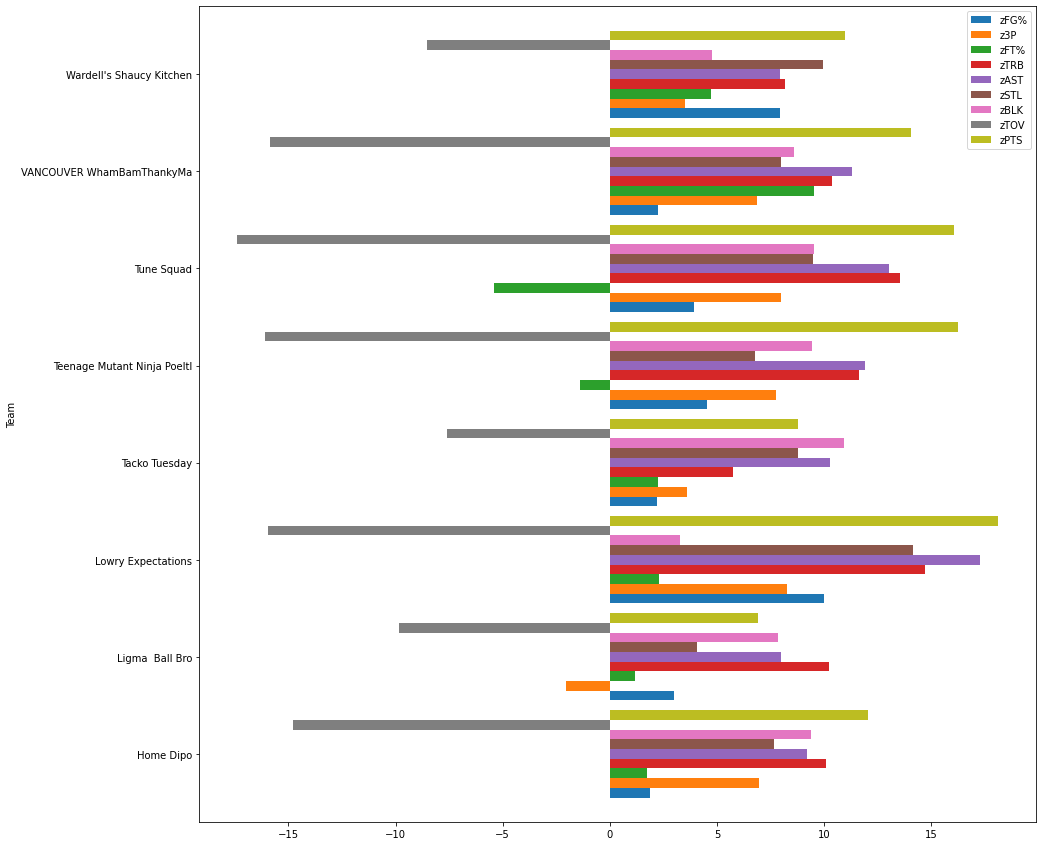

In [21]:
#plot the 9 fantasy categories as a comparison between teams.
zteam.plot(x = 'Team', y = z_fantasy_cats[:-1], kind = 'barh', figsize = (15,15), width = 0.9)

In fantasy basketball, a common draft strategy is to select several categories to completely lose out on, in other words, 'punt'. The theory is that you want to draft a group of basketball players that are strong in simular categories in order to consistently win the same categories in the weekly matchups. 

From the following analysis and an extremely limited sample size, we can see that there is no significant correlation between the standard deviation of all categories in each row with the overall strength of your team.

While it is tempting to draw a conclusion from these results, there is not enough sample size to do so. An excellent idea would be to observe the ESPN top 150 teams and plot them in a similar way. But alas, that is for a different project.

In [22]:
#drop zTotal column so that it is not factored into the deviation
cat9 = ['FG%','FT%','3P','PTS','TRB','AST','STL','BLK','TOV']
variation = zteam.drop('zTotal', axis = 1)

#calculate standard deviation
variation['deviation'] = variation.std(axis = 1)

#re-add ztotal to DataFrame
variation['zTotal'] = zteam['zTotal']

#Rank zscore to be compared with the ranking of deviation
variation['rankingZ'] = variation['zTotal'].rank(ascending = True)
variation['rankingD'] = variation['deviation'].rank(ascending = True)
variation = variation.sort_values('deviation', ascending = False)

variation.head(9)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Team,zFG%,z3P,zFT%,zTRB,zAST,zSTL,zBLK,zTOV,zPTS,deviation,zTotal,rankingZ,rankingD
5,Tune Squad,3.940782,7.996100,-5.425319,13.547261,13.003401,9.462015,9.509304,-17.375884,16.054015,10.696880,50.711675,5.0,8.0
2,Lowry Expectations,9.988383,8.270682,2.272692,14.703612,17.265248,14.141999,3.282420,-15.953035,18.130536,10.629948,72.102538,8.0,7.0
4,Teenage Mutant Ninja Poeltl,4.534896,7.748677,-1.381733,11.639190,11.905200,6.790682,9.425239,-16.077608,16.246588,9.552626,50.831132,6.0,6.0
6,VANCOUVER WhamBamThankyMa,2.236112,6.854213,9.516223,10.360028,11.297931,7.991752,8.591870,-15.863208,14.049864,8.857937,55.034785,7.0,5.0
0,Home Dipo,1.892709,6.962937,1.752154,10.064463,9.203701,7.678934,9.381063,-14.797128,12.042512,8.179211,44.181345,2.0,4.0
1,Ligma Ball Bro,3.003393,-2.025339,1.163933,10.228211,7.969790,4.080658,7.825414,-9.831992,6.889973,6.217169,29.304039,1.0,3.0
7,Wardell's Shaucy Kitchen,7.931908,3.526430,4.709882,8.155281,7.957726,9.926309,4.762580,-8.513384,10.973135,5.809367,49.429867,4.0,2.0
3,Tacko Tuesday,2.183713,3.618842,2.235638,5.766085,10.280426,8.762286,10.936712,-7.607469,8.766986,5.793186,44.943218,3.0,1.0


<Figure size 1440x720 with 0 Axes>

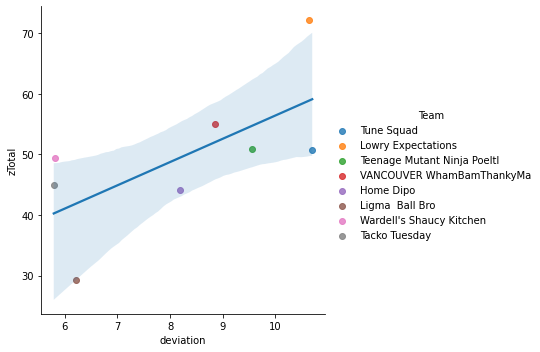

In [23]:
plt.figure(figsize = (20,10))
#create scatter plot
graph = sns.lmplot(data = variation, x = 'deviation', y = 'zTotal', hue = 'Team')
#create line of best fit
ax = sns.regplot(data = variation, x = 'deviation', y = 'zTotal', scatter=False, ax=graph.axes[0, 0])

Another important aspect of fantasy basketball drafting is the efficient use of budget in an auction draft. There are two common strategies:

1. Draft 2-3 high value & high cost players, then fill out the rest of the roster with low cost but high potential players. In this strategy, you assume that you are able to trust in your judgement of free agents as well as low cost players.

2. Draft an entire team of medium value & medium cost players. In this strategy, you assume that you can obtain players for good value in the middle rounds of the draft, as other players are paying high cost for the best players in the league.

I attempt to analyze these different strategies with the use of a boxplot overlaid on top of a swarmplot. The tighter your boxplot is, the more the value of your players are similar to each other.

In theory, I should've used the actual price of each player rather than their performance. However, I am unable to access the auction draft details through the API, although I am working on a Github contribution to complete it.


In [24]:
#find the standard deviation of each player's statistics for each Fantasy Team
stdevplayers = fantasy_stats.groupby('Team').std().reset_index()
stdevplayers = stdevplayers.sort_values('zTotal', ascending = False)
stdevplayers.head(9)

,Team,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
2,Lowry Expectations,2.009305,1.191500,1.190153,0.903300,1.285018,1.555845,1.339738,0.627962,1.343307,4.987702
4,Teenage Mutant Ninja Poeltl,1.718358,1.824713,1.161181,1.230617,1.401957,0.784103,0.610081,1.324420,0.918322,4.766934
5,Tune Squad,1.861577,2.179816,1.021738,0.931720,1.370396,1.163578,0.974110,1.667791,1.200217,4.587598
7,Wardell's Shaucy Kitchen,1.194296,1.872414,1.303833,1.258307,1.334163,1.075701,0.974139,1.376244,1.136215,4.155349
0,Home Dipo,0.771928,1.788236,1.146544,1.291633,0.966708,1.668952,0.830193,1.343606,1.430691,3.821933
3,Tacko Tuesday,1.156387,1.450974,1.141117,0.729674,1.139604,1.702921,1.514832,1.983849,0.930230,3.809528
6,VANCOUVER WhamBamThankyMa,1.503153,1.442583,1.308608,0.916687,1.206037,1.325429,0.988941,1.549296,1.198252,3.747870
1,Ligma Ball Bro,1.417048,1.374138,0.947522,1.031842,1.082376,0.831397,0.888105,1.028022,0.911543,3.158548


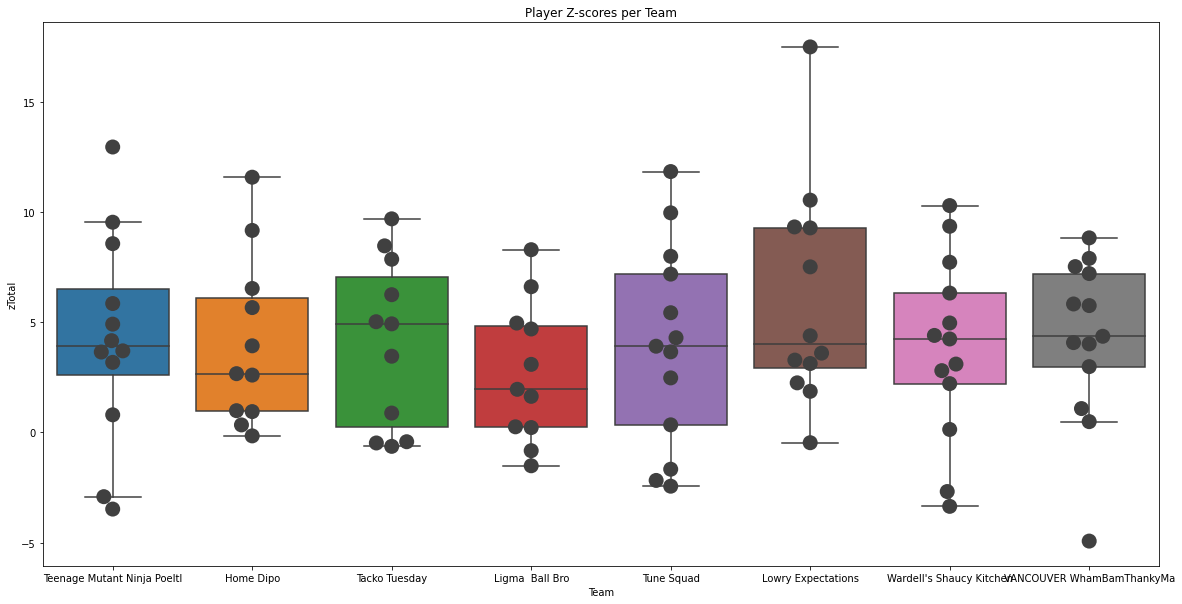

In [25]:
plt.figure(figsize = (20,10))
plt.title('Player Z-scores per Team')
#graphing the boxplot
ax = sns.boxplot(data = fantasy_stats, x = 'Team', y = 'zTotal')
#graphing the swarmplot
ax = sns.swarmplot(data = fantasy_stats, x = 'Team', y = 'zTotal', size = 15, color = '.25')

Here, I rank each team in every single category, as well as their total rank.

In [26]:
cat10 = ['FG%','FT%','3P','PTS','TRB','AST','STL','BLK','TOV','Total']
def team_rankings(zteam):
    zteam['FG%'] = zteam['zFG%'].rank(ascending = True)
    zteam['FT%'] = zteam['zFT%'].rank(ascending = True)
    zteam['3P'] = zteam['z3P'].rank(ascending = True)
    zteam['PTS'] = zteam['zPTS'].rank(ascending = True)
    zteam['TRB'] = zteam['zTRB'].rank(ascending = True)
    zteam['AST'] = zteam['zAST'].rank(ascending = True)
    zteam['STL'] = zteam['zSTL'].rank(ascending = True)
    zteam['BLK'] = zteam['zBLK'].rank(ascending = True)
    zteam['TOV'] = zteam['zTOV'].rank(ascending = True)
    zteam['Total'] = zteam['zTotal'].rank(ascending = True)
    
    #appending the original team column to my cat10 columns
    new = zteam[['Team']+cat10].copy().sort_values('Total', ascending = False)
    return new


rankings = team_rankings(zteam)
rankings.head(9)

,Team,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV,Total
2,Lowry Expectations,8.0,6.0,8.0,8.0,8.0,8.0,8.0,1.0,3.0,8.0
6,VANCOUVER WhamBamThankyMa,3.0,8.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,7.0
4,Teenage Mutant Ninja Poeltl,6.0,2.0,6.0,7.0,6.0,6.0,2.0,6.0,2.0,6.0
5,Tune Squad,5.0,1.0,7.0,6.0,7.0,7.0,6.0,7.0,1.0,5.0
7,Wardell's Shaucy Kitchen,7.0,7.0,2.0,3.0,2.0,1.0,7.0,2.0,7.0,4.0
3,Tacko Tuesday,2.0,5.0,3.0,2.0,1.0,4.0,5.0,8.0,8.0,3.0
0,Home Dipo,1.0,4.0,5.0,4.0,3.0,3.0,3.0,5.0,5.0,2.0
1,Ligma Ball Bro,4.0,3.0,1.0,1.0,4.0,2.0,1.0,3.0,6.0,1.0


In [27]:
len(league.recent_activity(200)) #number of transactions

159

In [28]:
transactions = league.recent_activity(200)